In [530]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/M1_S2/ML/ProjetML
import numpy as np
from mltools import *
import copy as cp

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/M1_S2/ML/ProjetML


# Linéaire

## Module

In [528]:
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    if labels is not None:
        labels = labels.reshape(-1)
    cols,marks = ["red", "green", "blue", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])

def plot_frontiere(data,f,step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).reshape(x.shape),colors=('gray','blue'),levels=[-1,0,1])

def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y

def gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=0,epsilon=0.02):
    """ Generateur de donnees,
        :param centerx: centre des gaussiennes
        :param centery:
        :param sigma: des gaussiennes
        :param nbex: nombre d'exemples
        :param data_type: 0: melange 2 gaussiennes, 1: melange 4 gaussiennes, 2:echequier
        :param epsilon: bruit dans les donnees
        :return: data matrice 2d des donnnes,y etiquette des donnnees
    """
    if data_type==0:
         #melange de 2 gaussiennes
         xpos=np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),nbex//2)
         xneg=np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),nbex//2)
         data=np.vstack((xpos,xneg))
         y=np.hstack((np.ones(nbex//2),-np.ones(nbex//2)))
    if data_type==1:
        #melange de 4 gaussiennes
        xpos=np.vstack((np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),nbex//4),np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),nbex//4)))
        xneg=np.vstack((np.random.multivariate_normal([-centerx,centerx],np.diag([sigma,sigma]),nbex//4),np.random.multivariate_normal([centerx,-centerx],np.diag([sigma,sigma]),nbex//4)))
        data=np.vstack((xpos,xneg))
        y=np.hstack((np.ones(nbex//2),-np.ones(nbex//2)))

    if data_type==2:
        #echiquier
        data=np.reshape(np.random.uniform(-4,4,2*nbex),(nbex,2))
        y=np.ceil(data[:,0])+np.ceil(data[:,1])
        y=2*(y % 2)-1
    # un peu de bruit
    data[:,0]+=np.random.normal(0,epsilon,nbex)
    data[:,1]+=np.random.normal(0,epsilon,nbex)
    # on mélange les données
    idx = np.random.permutation((range(y.size)))
    data=data[idx,:]
    y=y[idx]
    return data,y.reshape(-1, 1)

def load(filename):
    f=open(filename,'r')
    s = f.readline() # virer la premiere ligne
    X = np.array([[float(d) for d in lig.split()] for lig in f if len(lig)>10])
    Y = X[:,0] # premiere colonne
    X = X[:,1:]
    f.close()
    return X,Y

In [561]:
class Loss(object):
    def forward(self, y, yhat):
        pass

    def backward(self, y, yhat):
        pass

class MSELoss(Loss):
    def forward(self, y, yhat):
        """ Calculer le coût en fonction des 2 entrées
        """
        return np.linalg.norm(y-yhat, axis=1)**2

    def backward(self, y, yhat):
        """ Calculer le gradient du cout par rapport yhat
        """
        return -2*(y-yhat)


class Module(object):
    def __init__(self):
        self._parameters = None
        self._gradient = None

    def zero_grad(self):
        ## Annule gradient
        pass

    def forward(self, X):
        ## Calcule la passe forward
        pass

    def update_parameters(self, gradient_step=1e-3):
        ## Calcule la mise a jour des parametres selon le gradient calcule et le pas de gradient_step
        self._parameters -= gradient_step*self._gradient

    def backward_update_gradient(self, input, delta):
        ## Met a jour la valeur du gradient
        pass

    def backward_delta(self, input, delta):
        ## Calcul la derivee de l'erreur
        pass

class Linear(Module):
    def __init__(self, input, output):
        """ Une couche linéaire dans le réseau de neurones

        Args:
            input (int): le nombre d'entrées
            output (int): le nombre de sorties
        """
        super().__init__()
        self._parameters = np.random.randn(output, input) # W
        #self._parameters = np.random.randn(input, output)
        #print(self._parameters.shape)
        self._gradient = np.zeros_like(self._parameters)

    def zero_grad(self):
        """ Réinitialiser à 0 le gradient
        """
        self._gradient = np.zeros_like(self._parameters)
    
    def forward(self, X):
        """ calculer les sorties du module pour les entrées passées en paramètre 
        """
        return np.dot(X,self._parameters.T) # <x,w>
        #return np.dot(X,self._parameters)
    
    
    def update_parameters(self, gradient_step=1e-3):
        """ Mettre à jour les paramètres du module selon le gradient accumulé 
            jusqu’à son appel avec un pas de gradient_step
        """ 
        self._parameters -= gradient_step*self._gradient
        #self._parameters /= np.linalg.norm(self._parameters)
        self.zero_grad()
        
    def backward_update_gradient(self, input, delta):
        """ On est dans la couche h, calculer le gradient du coût par
            rapport aux paramètres et l’additionner à la variable _gradient
            - en fonction de l’entrée input et des δ de la couche suivante delta

        Args:
            input (array): z_h-1
            delta (_type_): _description_
        """
        #print(f"LIN MAJ GRAD input {input.shape} delta {delta.shape}")
        #print("BW_grad_Lin",delta.T.shape, input.shape)
        gradient = delta.T@input
        #print(gradient.shape)
        #print(self._gradient.shape)
        #gradient = np.dot(input.T, delta)
        # print(gradient.shape)
        # print(self._gradient.shape)
        self._gradient += gradient
        

    def backward_delta(self, input, delta):
        """ calculer le gradient du coût par rapport aux entrées 
            en fonction de l’entrée input et des deltas de la couche
            suivante delta
        """
        #print(f"LIN input {input.shape} delta {delta.shape} w {self._parameters.shape}")
        return np.dot(delta, self._parameters)
        #return np.dot(delta, self._parameters.T)
    

class TanH(Module): # (e(z)-e(-z)) / (e(z)+e(-z))
    def __init__(self):
        """ Une couche tanH dans le réseau de neurones
        """
        super().__init__()
        

    def zero_grad(self):
        """ Réinitialiser à 0 le gradient
        """
        pass
    
    def forward(self, X):
        """ calculer les sorties du module pour les entrées passées en paramètre 
        """
        return  np.tanh(X)
    
    
    def update_parameters(self, gradient_step=1e-3):
        """ Mettre à jour les paramètres du module selon le gradient accumulé 
            jusqu’à son appel avec un pas de gradient_step
        """ 
        pass
        
    def backward_update_gradient(self, input, delta):
        """ On est dans la couche h, calculer le gradient du coût par
            rapport aux paramètres et l’additionner à la variable _gradient
            - en fonction de l’entrée input et des δ de la couche suivante delta

        Args:
            input (array): z_h-1
            delta (_type_): _description_
        """
        pass
        

    def backward_delta(self, input, delta):
        """ calculer le gradient du coût par rapport aux entrées 
            en fonction de l’entrée input et des deltas de la couche
            suivante delta
        """
        #print(f"TANH input {input.shape} delta {delta.shape}")
        return delta * (1 - np.tanh(input) ** 2) 
    
class Sigmoide(Module): # 1 / (1+e(-z))
    def __init__(self):
        """ Une couche tanH dans le réseau de neurones
        """
        super().__init__()
        

    def zero_grad(self):
        """ Réinitialiser à 0 le gradient
        """
        pass
    
    def forward(self, X):
        """ calculer les sorties du module pour les entrées passées en paramètre 
        """
        return  1/(1+np.exp(-X))
    
    def update_parameters(self, gradient_step=1e-3):
        """ Mettre à jour les paramètres du module selon le gradient accumulé 
            jusqu’à son appel avec un pas de gradient_step
        """ 
        pass
        
    def backward_update_gradient(self, input, delta):
        """ On est dans la couche h, calculer le gradient du coût par
            rapport aux paramètres et l’additionner à la variable _gradient
            - en fonction de l’entrée input et des δ de la couche suivante delta

        Args:
            input (array): z_h-1
            delta (_type_): _description_
        """
        pass
        

    def backward_delta(self, input, delta):
        """ calculer le gradient du coût par rapport aux entrées 
            en fonction de l’entrée input et des deltas de la couche
            suivante delta
        """
        #print(f"SIG input {input.shape} delta {delta.shape}")
        return  delta * (1/(1+np.exp(-input))) * (1 - (1/(1+np.exp(-input))))   


## Une couche

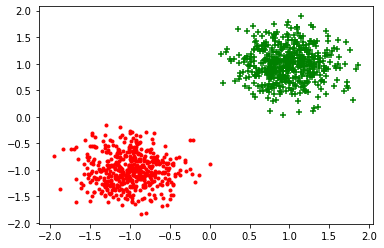

In [4]:
np.random.seed(0)
X, Y = gen_arti()
plot_data(X,Y)

Acc: 0.0


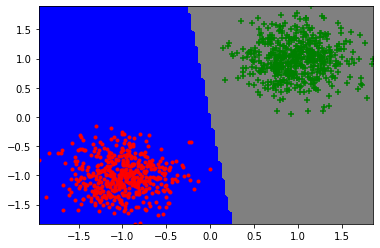

In [5]:
np.random.seed(2)
M = Linear(X.shape[1], 1)
#print(M._parameters)
y_pred = M.forward(X)
y_hat = np.sign(y_pred)
plot_frontiere(X,lambda x : np.sign(M.forward(x)),step=100)
plot_data(X,Y)
res = np.where(y_hat == Y, 1, 0).sum()
print("Acc:",res/len(Y))

Acc: 1.0


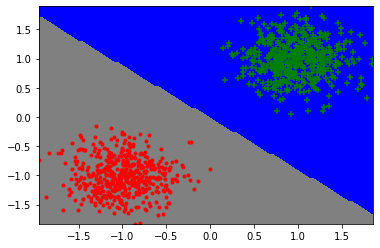

In [6]:
loss = MSELoss()
L = loss.forward(Y,y_hat)
delta = loss.backward(Y,y_pred)
M.backward_update_gradient(X,delta)
M.update_parameters()
#print(M._parameters)
y_pred = M.forward(X)
y_hat = np.sign(y_pred)
plot_frontiere(X,lambda x : np.sign(M.forward(x)),step=100)
plot_data(X,Y)
res = np.where(y_hat == Y, 1, 0).sum()
print("Acc:",res/len(Y))

## Deux couches

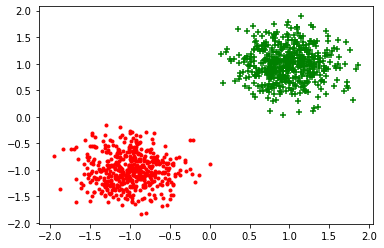

In [7]:
np.random.seed(0)
X, Y = gen_arti()
plot_data(X,Y)

Acc: 0.538


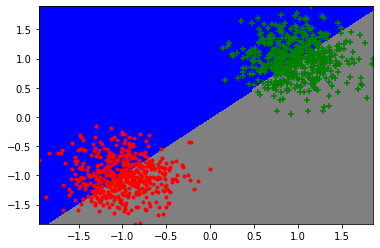

In [8]:
np.random.seed(3)
# Couche 1: 2 neurones, couche 2: 1 neurone
M1 = Linear(X.shape[1], 2)
M2 = Linear(M1._parameters.shape[0], 1)
#print(M1._parameters, M2._parameters)
z_1 = M1.forward(X)
z_2 = M2.forward(z_1)
y_hat = np.sign(z_2)


#print(z_1.shape)
#print(z_2.shape)
#print(M2._parameters)
#print(M2._parameters.shape)
plot_frontiere(X,lambda x : np.sign(M2.forward(M1.forward(x))),step=100)
plot_data(X,Y)
res = np.where(y_hat == Y, 1, 0).sum()
print("Acc:",res/len(Y))

Acc: 0.943


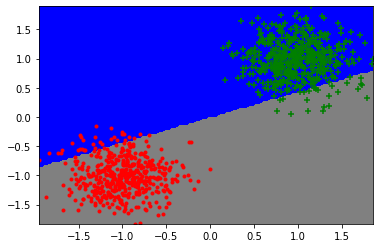

In [9]:
#Back propagation
loss = MSELoss()
delta2 = loss.backward(Y,z_2)
#M2
M2.backward_update_gradient(X,delta2)
delta1= M2.backward_delta(z_1, delta2)
M2.update_parameters(gradient_step=1e-4) # eps 1e-3 trop grand -> sortir de min local

#M1
M1.backward_update_gradient(X,delta1)
M1.update_parameters(gradient_step=1e-4)

#Foward
z_1 = M1.forward(X)
z_2 = M2.forward(z_1)
y_hat = np.sign(z_2)
plot_frontiere(X,lambda x : np.sign(M2.forward(M1.forward(x))),step=100)
plot_data(X,Y)
res = np.where(y_hat == Y, 1, 0).sum()
print("Acc:",res/len(Y))

# Non-linéaire

Lin-Tanh-Lin-Sig

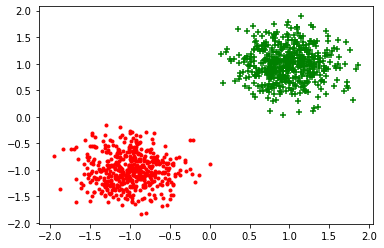

In [509]:
np.random.seed(0)
X, Y = gen_arti()
Y = np.where(Y==-1,0,1)
plot_data(X,Y)

Acc: 0.035


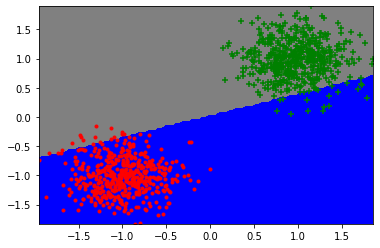

In [510]:
np.random.seed(6)
#ini
MLin1 = Linear(X.shape[1],2)
MtanH = TanH()
MLin2 = Linear(MLin1._parameters.shape[0], 1) #w_h1(out,in)
MSig = Sigmoide()
#forward
z_1 = MLin1.forward(X)
z_1_tan = MtanH.forward(z_1)
z_2 = MLin2.forward(z_1_tan)
z_2_sig = MSig.forward(z_2)
#decision
y_pred = np.where(z_2_sig>0.5,1,0)

def f_sig(X):
  A = MSig.forward(MLin2.forward(MtanH.forward(MLin1.forward(X))))
  return np.where(A>0.5,1,0)

#plot
plot_frontiere(X,f_sig,step=100)
plot_data(X,Y)
res = np.where(y_pred == Y, 1, 0).sum()
print("Acc:",res/len(Y))

Iter 1, Accuracy: 0.095
Iter 2, Accuracy: 0.16
Iter 3, Accuracy: 0.27
Iter 4, Accuracy: 0.426
Iter 5, Accuracy: 0.6
Iter 6, Accuracy: 0.734
Iter 7, Accuracy: 0.822
Iter 8, Accuracy: 0.875
Iter 9, Accuracy: 0.911
Iter 10, Accuracy: 0.941


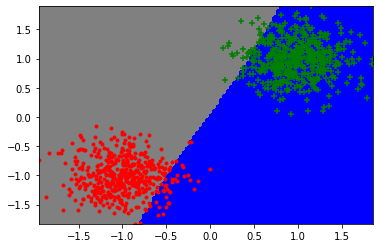

In [512]:
nbiter = 10
for i in range(nbiter):
  #Back propagation
  loss = MSELoss()
  delta_sortie = loss.backward(Y,z_2_sig)
  #Sig
  delta_sig = MSig.backward_delta(z_2,delta_sortie)
  #Lineaire 2
  MLin2.backward_update_gradient(z_1_tan,delta_sig)
  delta_2 = MLin2.backward_delta(z_1_tan, delta_sig)
  MLin2.update_parameters(gradient_step=1e-4)
  #TanH
  delta_tanH = MtanH.backward_delta(z_1,delta_2)
  #Lineaire 2
  MLin1.backward_update_gradient(X,delta_tanH)
  MLin1.update_parameters(gradient_step=1e-4)


  #forward
  z_1 = MLin1.forward(X)
  z_1_tan = MtanH.forward(z_1)
  z_2 = MLin2.forward(z_1_tan)
  z_2_sig = MSig.forward(z_2)
  #decision
  y_pred = np.where(z_2_sig>0.5,1,0)


  #plot
  plot_frontiere(X,f_sig,step=100)
  plot_data(X,Y)
  res = np.where(y_pred == Y, 1, 0).sum()
  print(f"Iter {i+1}, Accuracy:",res/len(Y))

# Encapsulage

## Sequentiel

In [108]:
def f_sig_seq(seq, X):
  A = seq.forward(X)
  return np.where(A>0.5,1,-1)


class Sequentiel():
  def __init__(self, *module):
    self.net = module

  def forward(self, input):
    z = input
    self.input = [input]
    for m in self.net:
      z = m.forward(z)
      self.input.append(z)
    return z
  
  def backward(self,loss, Y,gradient_step=0.001):
    delta_ = loss.backward(Y,self.input[-1])
    #print(len(self.input), len(self.net))
    for i in range(len(self.net)-1,-1,-1): # BACKKKKWARDDDDDDDD
      #print(type(self.net[i]).__name__)
      if type(self.net[i]).__name__ != 'Linear': # si fonction d'activation
        #print(f"SEQ ACTI {type(self.net[i]).__name__} input {self.input[i].shape} delta {delta_.shape}")
        delta_ = self.net[i].backward_delta(self.input[i], delta_)
      else: #Lineaire
        #print("LIN")
        #print(f"SEQ LIN {type(self.net[i]).__name__} input {self.input[i].shape} delta {delta_.shape}")
        self.net[i].backward_update_gradient(self.input[i],delta_)
        delta_ = self.net[i].backward_delta(self.input[i], delta_)
        self.net[i].update_parameters(gradient_step=gradient_step)


### Test Sequentiel

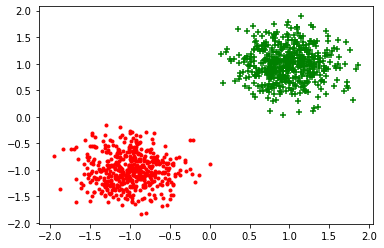

In [513]:
np.random.seed(0)
X, Y = gen_arti()
Y = np.where(Y==-1,0,1)
plot_data(X,Y)

Acc: 0.035


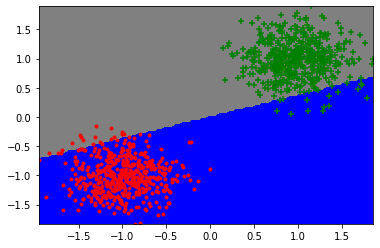

In [514]:
np.random.seed(6) # pour assurer c'est identique pour les tests
#ini
MLin1 = Linear(X.shape[1],2)
MtanH = TanH()
MLin2 = Linear(MLin1._parameters.shape[0], 1) #w_h1(out,in)
MSig = Sigmoide()
#ini seq
net = Sequentiel(MLin1, MtanH, MLin2, MSig)
#forward
z = net.forward(X)
#decision
y_pred = np.where(z>0.5,1,0)

net_copy = cp.deepcopy(net) # afin de ne pas modifier notre network

#plot
plot_frontiere(X,lambda x : f_sig_seq(net_copy, x),step=100)
plot_data(X,Y)
res = np.where(y_pred == Y, 1, 0).sum()
print("Acc:",res/len(Y))

Iter 1, Accuracy: 0.061
Iter 2, Accuracy: 0.095
Iter 3, Accuracy: 0.16
Iter 4, Accuracy: 0.27
Iter 5, Accuracy: 0.426
Iter 6, Accuracy: 0.6
Iter 7, Accuracy: 0.734
Iter 8, Accuracy: 0.822
Iter 9, Accuracy: 0.875
Iter 10, Accuracy: 0.911


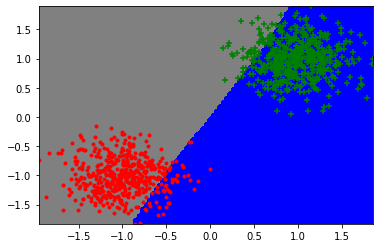

In [515]:
nbiter = 10
for i in range(nbiter):
  #Back propagation
  net.backward(MSELoss(), Y,gradient_step=1e-4)


  #forward
  z = net.forward(X)
  #decision
  y_pred = np.where(z>0.5,1,0)

  net_copy = cp.deepcopy(net)

  #plot
  plot_frontiere(X,lambda x : f_sig_seq(net_copy, x),step=100)
  plot_data(X,Y)
  res = np.where(y_pred == Y, 1, 0).sum()
  print(f"Iter {i+1}, Accuracy:",res/len(Y))

## Optim

In [516]:
class Optim():
  def __init__(self, net, loss, eps):
    self.net = net
    self.loss = loss
    self.eps = eps

  def step(self, batch_x, batch_y):
    y_hat = self.net.forward(batch_x)
    loss = self.loss.forward(batch_y, y_hat)
    self.net.backward(self.loss, batch_y,gradient_step=self.eps)
    return y_hat, loss

### Test Optim

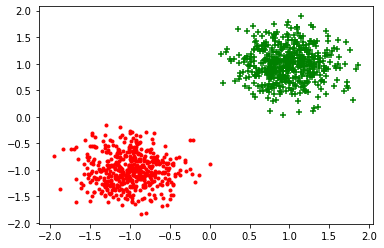

In [517]:
np.random.seed(0)
X, Y = gen_arti()
Y = np.where(Y==-1,0,1)
plot_data(X,Y)

In [518]:
np.random.seed(6)
#ini
MLin1 = Linear(X.shape[1],2)
MtanH = TanH()
MLin2 = Linear(MLin1._parameters.shape[0], 1) #w_h1(out,in)
MSig = Sigmoide()
#ini seq
net = Sequentiel(MLin1, MtanH, MLin2, MSig)
# Optim
eps = 1e-4
Opt = Optim(net, MSELoss(), eps)
y_hat, _ = Opt.step(X,Y)

#decision
y_pred = np.where(y_hat>0.5,1,0)

res = np.where(y_pred == Y, 1, 0).sum()
print("Acc:",res/len(Y))

Acc: 0.035


Iter 1, Accuracy: 0.061
Iter 2, Accuracy: 0.095
Iter 3, Accuracy: 0.16
Iter 4, Accuracy: 0.27
Iter 5, Accuracy: 0.426
Iter 6, Accuracy: 0.6
Iter 7, Accuracy: 0.734
Iter 8, Accuracy: 0.822
Iter 9, Accuracy: 0.875
Iter 10, Accuracy: 0.911


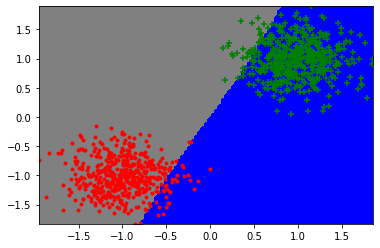

In [519]:
Opt = Optim(net, MSELoss(), eps)
nbiter = 10
for i in range(nbiter):
  y_hat, _ = Opt.step(X,Y)

  #decision
  y_pred = np.where(y_hat>0.5,1,0)

  net_copy = cp.deepcopy(net)

  #plot
  plot_frontiere(X,lambda x : f_sig_seq(net_copy, x),step=100)
  plot_data(X,Y)
  res = np.where(y_pred == Y, 1, 0).sum()
  print(f"Iter {i+1}, Accuracy:",res/len(Y))

La frontière est différente car il s'agit de la frontière de l'epoch prochain comme step met à jours les parametres du réseau

## SGD

In [132]:
def SGD(net, data, loss, eps=1e-4, batch_taille=40, nb_iter=5):
  """Apprentissage du réseaux en utilisant mini-batch et descente de gradient
  Arg:
  net: le réseau de neurones
  data: le jeu de données X, Y
  loss: fonction cout
  eps: pas de gradient
  batch_taille: la taille de chaque batch
  nb_inter: nombre d'itérations
  """
  opt = Optim(net, loss, eps)
  n = len(data)
  data_train = cp.deepcopy(data)
  for i in range(nb_iter): # pour chaque epochs
    np.random.shuffle(data_train)
    tab_mini_batches = [data_train[k:k+batch_taille] for k in range(0, n, batch_taille)] #decouper en mini batches
    for mini_batch in tab_mini_batches: # apprentissage sur chaque mini batch
      batch_x, batch_y = np.array(mini_batch[:,0].tolist()), np.array(mini_batch[:,1].tolist()) # array de array -> array de liste
      opt.step(batch_x, batch_y)

### Test SGD

<ipython-input-523-f6df407cdf9f>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([np.array([x,y]).tolist() for x, y in zip(X,Y)]) #merge x et y en un jeu de données


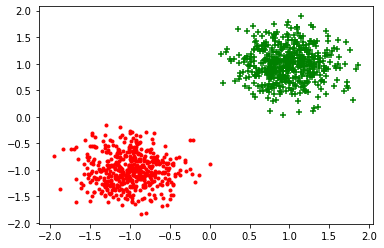

In [523]:
np.random.seed(0)
X, Y = gen_arti()
Y = np.where(Y==-1,0,1)
data = np.array([np.array([x,y]).tolist() for x, y in zip(X,Y)]) #merge x et y en un jeu de données
plot_data(X,Y)

In [524]:
np.random.seed(6)
#ini
MLin1 = Linear(X.shape[1],2)
MtanH = TanH()
MLin2 = Linear(MLin1._parameters.shape[0], 1) #w_h1(out,in)
MSig = Sigmoide()
#ini seq
net = Sequentiel(MLin1, MtanH, MLin2, MSig)

Acc: 0.903


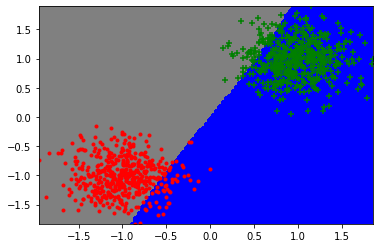

In [525]:
SGD(net, data, MSELoss(), eps=1e-4, batch_taille=40, nb_iter=10)

y_hat = net.forward(X)
#decision
y_pred = np.where(y_hat>0.5,1,0)

net_copy = cp.deepcopy(net) # afin de ne pas modifier notre network

#plot
plot_frontiere(X,lambda x : f_sig_seq(net_copy, x),step=100)
plot_data(X,Y)
res = np.where(y_pred == Y, 1, 0).sum()
print("Acc:",res/len(Y))

# Multi-classe

# Softmax et Cout entropique

In [526]:
def logsoftmax(y):
  return np.exp(y)/np.sum(np.exp(y), axis = 1)[:, np.newaxis]

class SMCELoss(Loss):
    def forward(self, y, yhat):
        """Coût cross-entropique
        y: indice de la classe à prédire, exp pour 1 exemple [0,0,0,1] -> classe 3
        y_hat: le vecteur de prédiction -> exp pour 1 exemple [0.1, 0.3, 0.4, 0.2]
        """
        #-yhat_y + log(sum_i(exp(yhat_i)))
        return -np.sum(y*yhat, axis = 1) + np.log(np.sum(np.exp(yhat), axis = 1))

    def backward(self, y, yhat):
        """ Calculer le gradient du cout par rapport yhat
        """
        exp_sum_exp = np.exp(yhat)/np.sum(np.exp(yhat), axis = 1)[:, np.newaxis] # 1/sum(exp(yhat_i))
        #tmp = np.ones_like(y) * exp_sum_exp # chaque ele d'une ligne est 1/sum_exp
        #print(tmp[:2])
        #tmp = a * sum_exp_inv[:, np.newaxis] # chaque ele d'une ligne est 1/sum_exp
        tmp_2 = np.where(y==1, -1, 0)
        #print(tmp_2[:2])
        #print((tmp + tmp_2)[:2])
        return exp_sum_exp + tmp_2 # ou y = 1 -> -1

## Data manuscrits

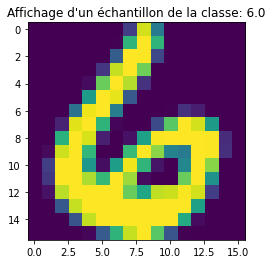

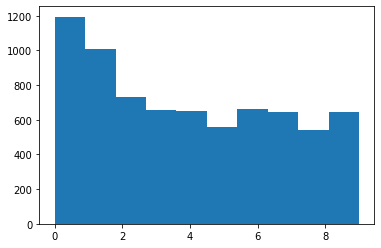

In [527]:
def load(filename):
    f=open(filename,'r')
    s = f.readline() # virer la premiere ligne
    X = np.array([[float(d) for d in lig.split()] for lig in f if len(lig)>10])
    Y = X[:,0] # premiere colonne
    X = X[:,1:]
    f.close()
    return X,Y

X,Y = load('data/usps_train.txt')
Xt,Yt = load('data/usps_test.txt')

# affichage d'un échantillon
plt.figure()
index = 0
plt.imshow(X[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

# étude très rapide des données:
plt.figure()
plt.hist(Y, 10) # histogramme de répartition des 10 classes
plt.show()

In [498]:
Y = Y.astype(int)
Y_onehot = np.zeros((Y.size,10));
Y_onehot[np.arange(Y.size),Y]=1
Y_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [501]:
np.random.seed(6)
#ini
MLin1 = Linear(X.shape[1],150)
MtanH = TanH()
MLin2 = Linear(MLin1._parameters.shape[0], 10) # 10 classes
MSig = Sigmoide()
#ini seq
net = Sequentiel(MLin1, MtanH, MLin2, MSig)

#forward
z = net.forward(X)

l = SMCELoss()
l.forward(Y_onehot, z)

# prediction = argmax
y_pred = np.argmax(logsoftmax(z), axis = 1)
# accu
res = np.where(y_pred == Y, 1, 0).sum()
print("Acc:",res/len(Y))

Acc: 0.06761761075298313


In [502]:
nbiter = 100
eps = 0.005
for i in range(nbiter):
  #Back propagation
  net.backward(SMCELoss(), Y_onehot,gradient_step=eps)

  #forward
  z = net.forward(X)

  # prediction = argmax
  y_pred = np.argmax(logsoftmax(z), axis = 1)
  # accu
  res = np.where(y_pred == Y, 1, 0).sum()
  print(f"Iter {i+1}, Accuracy:",res/len(Y))

Iter 1, Accuracy: 0.2216431216568372
Iter 2, Accuracy: 0.39459607735564395
Iter 3, Accuracy: 0.5133726512138252
Iter 4, Accuracy: 0.6045809902619668
Iter 5, Accuracy: 0.6571115073378138
Iter 6, Accuracy: 0.6933205321629407
Iter 7, Accuracy: 0.7110135783843095
Iter 8, Accuracy: 0.7248662734878617
Iter 9, Accuracy: 0.7259635166643807
Iter 10, Accuracy: 0.7499657111507337
Iter 11, Accuracy: 0.7779454121519682
Iter 12, Accuracy: 0.7889178439171581
Iter 13, Accuracy: 0.8005760526676725
Iter 14, Accuracy: 0.8066108901385269
Iter 15, Accuracy: 0.8111370182416678
Iter 16, Accuracy: 0.821835139212728
Iter 17, Accuracy: 0.8151145247565492
Iter 18, Accuracy: 0.8336305033603072
Iter 19, Accuracy: 0.8439171581401728
Iter 20, Accuracy: 0.8432313811548484
Iter 21, Accuracy: 0.853518035934714
Iter 22, Accuracy: 0.8515978603758058
Iter 23, Accuracy: 0.8610615827732822
Iter 24, Accuracy: 0.8544781237141682
Iter 25, Accuracy: 0.8643533123028391
Iter 26, Accuracy: 0.8563982992730764
Iter 27, Accuracy: 0.8

Test SGD

In [506]:
X,Y = load('data/usps_train.txt')
Xt,Yt = load('data/usps_test.txt')
Y = Y.astype(int)
Y_onehot = np.zeros((Y.size,10));
Y_onehot[np.arange(Y.size),Y]=1

data = np.array([np.array([x,y]).tolist() for x, y in zip(X,Y_onehot)])

<ipython-input-506-cdb086115867>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([np.array([x,y]).tolist() for x, y in zip(X,Y_onehot)])


In [507]:
np.random.seed(6)
#ini le reseau
MLin1 = Linear(X.shape[1],256)
MSig1 = Sigmoide()
MLin2 = Linear(MLin1._parameters.shape[0], 128)
MSig2 = Sigmoide()
MLin3 = Linear(MLin2._parameters.shape[0], 10) # 10 classes
MSig3 = Sigmoide()
#ini seq
net = Sequentiel(MLin1, MSig1, MLin2, MSig2,MLin3,MSig3)

In [508]:
# SGD
SGD(net, data, SMCELoss(), eps=1e-2, batch_taille=300, nb_iter=100)

z = net.forward(X)

# prediction = argmax
y_pred = np.argmax(logsoftmax(z), axis = 1)
# accu
res = np.where(y_pred == Y, 1, 0).sum()
print("Acc:",res/len(Y))

Acc: 0.8996022493485119


# Se compresser

Text(0.5, 1.0, "Affichage d'un échantillon de la classe: 6.0")

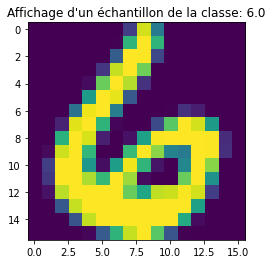

In [623]:
X,Y = load('data/usps_train.txt')

# affichage d'un échantillon
plt.figure()
index = 0
plt.imshow(X[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

In [624]:
class BCELoss(Loss):
    def forward(self, y, yhat):
        """Coût cross-entropique binaire
        y: indice de la classe à prédire, exp pour 1 exemple [0,0,0,1] -> classe 3
        y_hat: le vecteur de prédiction -> exp pour 1 exemple [0.1, 0.3, 0.4, 0.2]
        """
        return -(y*np.log(yhat) + (1-y)*np.log(1-yhat))

    def backward(self, y, yhat):
        """ Calculer le gradient du cout par rapport yhat
        """
        yhat = np.where(yhat == 0, 1e-9, yhat)
        yhat = np.where(yhat == 1, 0.999999999, yhat)
        return -(y/yhat + (y-1)/(1-yhat))

## Tester sur 1 image

In [643]:
img = X[0].reshape(-1,256)

Text(0.5, 1.0, "Affichage d'un échantillon de la classe: 6.0")

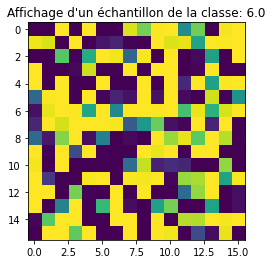

In [644]:
np.random.seed(6) # pour assurer c'est identique pour les tests
#Encodage
MLin1_encodage = Linear(256,100)
MtanH1_encodage = TanH()
MLin2_encodage = Linear(MLin1_encodage._parameters.shape[0], 10)
MtanH2_encodage = TanH()

#Decodage
MLin1_decodage = Linear(10,100)
MtanH_decodage = TanH()
MLin2_decodage = Linear(MLin1_decodage._parameters.shape[0], 256)
MSig_decodage = Sigmoide()
#Seq encodage-decodage
net = Sequentiel(MLin1_encodage, MtanH1_encodage, MLin2_encodage, MtanH2_encodage, MLin1_decodage, MtanH_decodage, MLin2_decodage, MSig_decodage)

z = net.forward(img)

# affichage d'un échantillon
plt.figure()
index = 0
plt.imshow(z[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

Text(0.5, 1.0, "Affichage d'un échantillon de la classe: 6.0")

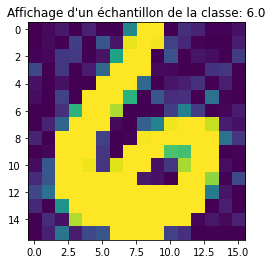

In [645]:
nbiter = 2500
for i in range(nbiter):
  #Back propagation
  net.backward(BCELoss(), img,gradient_step=1e-4)
  #forward
  z = net.forward(img)

# affichage d'un échantillon
plt.figure()
index = 0
plt.imshow(z[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

Text(0.5, 1.0, "Affichage d'un échantillon de la classe: 3.0")

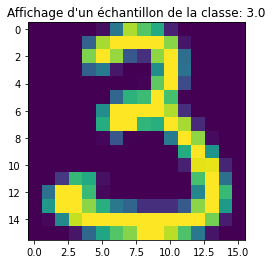

In [646]:
# affichage d'un échantillon
plt.figure()
index = 4
plt.imshow(X[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

Text(0.5, 1.0, "Affichage d'un échantillon de la classe: 3.0")

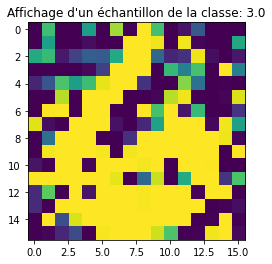

In [647]:
index_img = 4
z = net.forward(X[index_img].reshape(-1,256))

# affichage d'un échantillon
plt.figure()
plt.imshow(z[0].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

## Tester sur N-image

Text(0.5, 1.0, "Affichage d'un échantillon de la classe: 6.0")

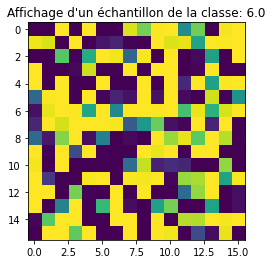

In [621]:
np.random.seed(6) # pour assurer c'est identique pour les tests
#Encodage
MLin1_encodage = Linear(256,100)
MtanH1_encodage = TanH()
MLin2_encodage = Linear(MLin1_encodage._parameters.shape[0], 10)
MtanH2_encodage = TanH()

#Decodage
MLin1_decodage = Linear(10,100)
MtanH_decodage = TanH()
MLin2_decodage = Linear(MLin1_decodage._parameters.shape[0], 256)
MSig_decodage = Sigmoide()
#Seq encodage-decodage
net = Sequentiel(MLin1_encodage, MtanH1_encodage, MLin2_encodage, MtanH2_encodage, MLin1_decodage, MtanH_decodage, MLin2_decodage, MSig_decodage)

z = net.forward(X)

# affichage d'un échantillon
plt.figure()
index = 0
plt.imshow(z[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

In [622]:
nbiter = 2000
for i in range(nbiter):
  #Back propagation
  net.backward(BCELoss(), X,gradient_step=1e-4)
  #forward
  z = net.forward(X)

# affichage d'un échantillon
plt.figure()
index = 0
plt.imshow(z[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

KeyboardInterrupt: ignored